In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split # For splitting the data for testing purposes
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns # For visualisations
import statsmodels.api as sm # For linear regression modelling
from statsmodels.graphics.gofplots import qqplot

from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions
import warnings # For handling error messages

In [2]:
#import the full, labelled data set
pots = pd.read_csv('Pots_clean_labelled.csv')
pots.head(1)

,productcode,price,maker,name,description,height,width,depth,materials,technique,firing,decoration,category
0,AM470Y165,47.0,Andy Mason,ovalled bowl cream satin motif,this stoneware bowl is wheel-thrown with a cre...,8.0,25.5,22.0,Stoneware,Thrown,Electric,Glaze,first


In [3]:
pots_encoded = pd.get_dummies(
                                pots.drop(columns=['productcode', 'category', 'name', 'maker', 'description']),
                                drop_first=True #Always drop one category as information is encoded in subsequent vars
                            )
pots_encoded.columns

Index(['price', 'height', 'width', 'depth', 'materials_Earthenware',
       'materials_Porcelain', 'materials_Stoneware', 'technique_Thrown',
       'firing_Gas', 'firing_Raku', 'firing_Wood', 'decoration_Lustre',
       'decoration_Sgraffito', 'decoration_Slip decoration',
       'decoration_Terra Sigillata'],
      dtype='object')

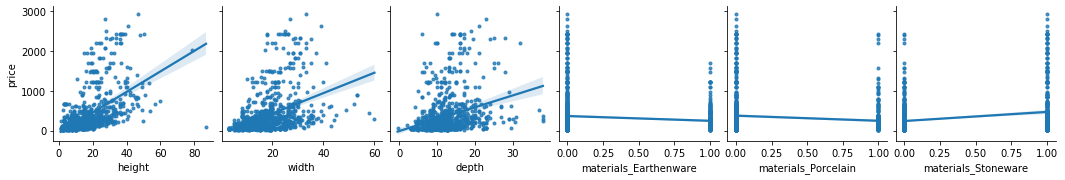

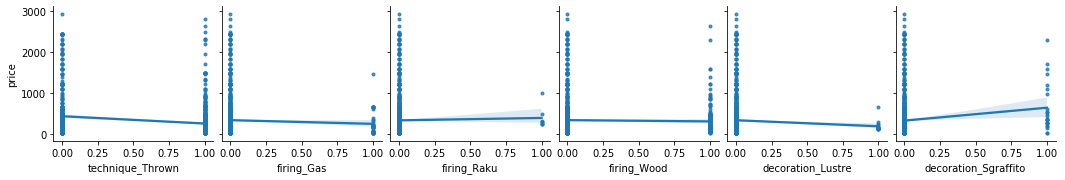

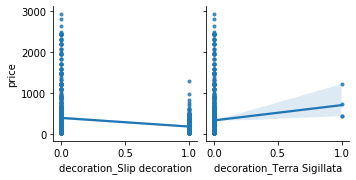

In [4]:
cols = pots_encoded.columns.drop('price')
n_cols = 6

for i in range(0, len(cols), n_cols):
    sns.pairplot(data=pots_encoded[pots_encoded['price'] < 3000], #exclude most expensive pots for visual purposes
             x_vars=cols[i:i+n_cols], 
             y_vars=['price'],
             markers='.',
             diag_kind=None, #needed to avoid broken pairplot logic (as of version 0.11.1)
             kind='reg')
    plt.show()

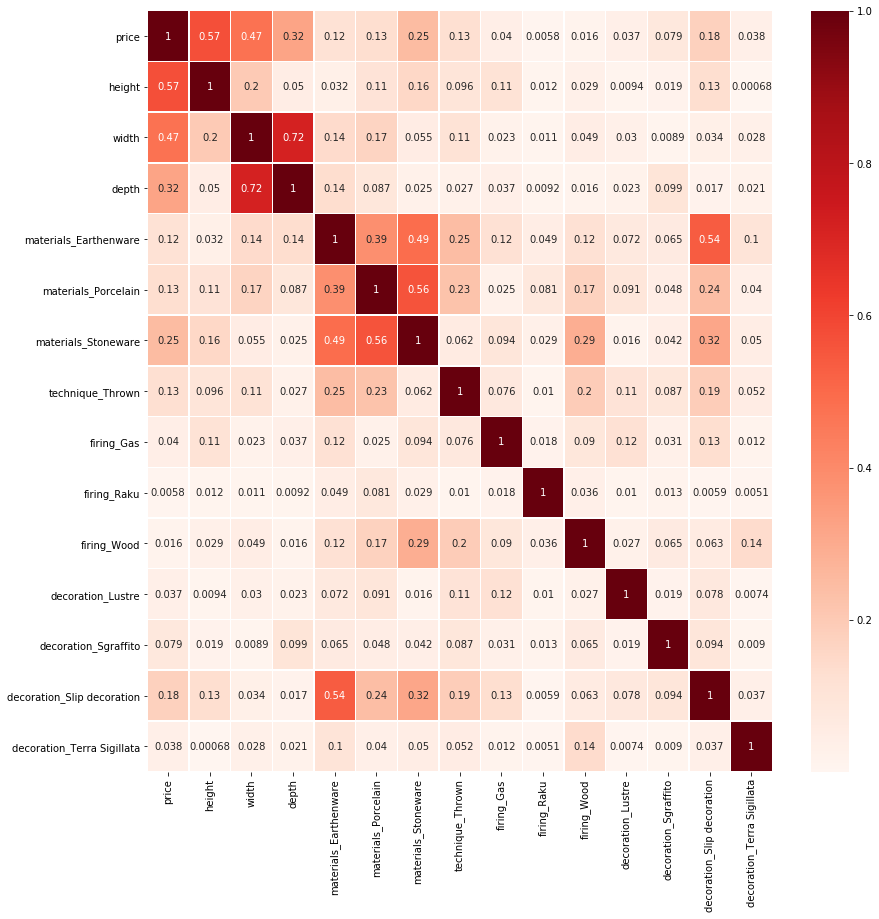

In [5]:
plt.figure(figsize=(14, 14))
sns.heatmap(abs(pots_encoded.corr()), annot = True, linewidths = 0.5, cmap = 'Reds')

There are three correlation clusters to take care of:
1. Width, depth
2. materials_Earthenware, materials_Porcelain, materials_Stoneware

Let's use the mean of width and depth and call it 'length'

In [6]:
pots_reg = pots_encoded.copy()

In [7]:
pots_reg['length'] = pots_reg[['depth', 'width']].mean(axis=1)
pots_reg.drop(columns=['depth', 'width'], inplace = True)

I will deal with the multicollinearity of the materials categorical variables using a regularized approach, if need be.

## Regressor function

In [8]:
def regressor(X, y, regression_class):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

    lin_reg = regression_class
    lin_reg.fit(X_train, y_train)

    print('intercept:', round(lin_reg.intercept_, 1))
    print('coefficients:', dict(zip(X.columns, lin_reg.coef_)))

    preds_train = lin_reg.predict(X_train)
    preds_test = lin_reg.predict(X_test)
    preds_all = lin_reg.predict(X)
    residuals = y - preds_all
    
    return X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals

def reg_errors(y_test, preds_test):
    
    mae = mean_absolute_error(y_test, preds_test)
    rmse = mean_squared_error(y_test, preds_test, squared=False)
    r2 = r2_score(y_test, preds_test)

    print('MAE:', round(mae, 1))
    print('RMSE:', round(rmse, 1))
    print('R^2:', round(r2, 3))
    
    return mae, rmse, r2
    
def reg_plots(func, string_description, regression_class):
    
    X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals = func(X, y, regression_class)

    mae, rmse, r2 = reg_errors(y_test, preds_test)
    
    fig, axes = plt.subplots(2, 2,figsize=(15,15))

    fig.suptitle("Regression: {}\n \
                 MAE = £{} \n \
                 RMSE = £{} \n \
                 R2 = {}".format(string_description, round(mae, 1), round(rmse, 1), round(r2,3)))

    sns.scatterplot(x = 'height', y = y_train, data = X_train, ax=axes[0, 0])
    sns.scatterplot(x = 'height', y = y_test, data = X_test, ax=axes[0, 0])
    sns.lineplot(x = 'height', y = preds_test, data = X_test, ax=axes[0, 0])
    axes[0, 0].set_title("Regression line")

    sns.histplot(residuals, kde = True, bins = 100, ax=axes[0,1])
    axes[0,1].set_title("Distribution of residuals (= y - predicted)")

    qqplot(residuals, line='45', fit=True, ax=axes[1,0])
    axes[1,0].set_title("Q-Q plot")

    sns.scatterplot(x=preds_all, y=residuals, ax=axes[1,1])
    axes[1,1].set_xlabel("predicted price")
    axes[1,1].set_ylabel("residuals")
    axes[1,1].set_title("Price vs price predicted")

## Simple linear regression

intercept: -98.6
coefficients: {'height': 29.962495391983268}
MAE: 225.5
RMSE: 363.5
R^2: 0.367


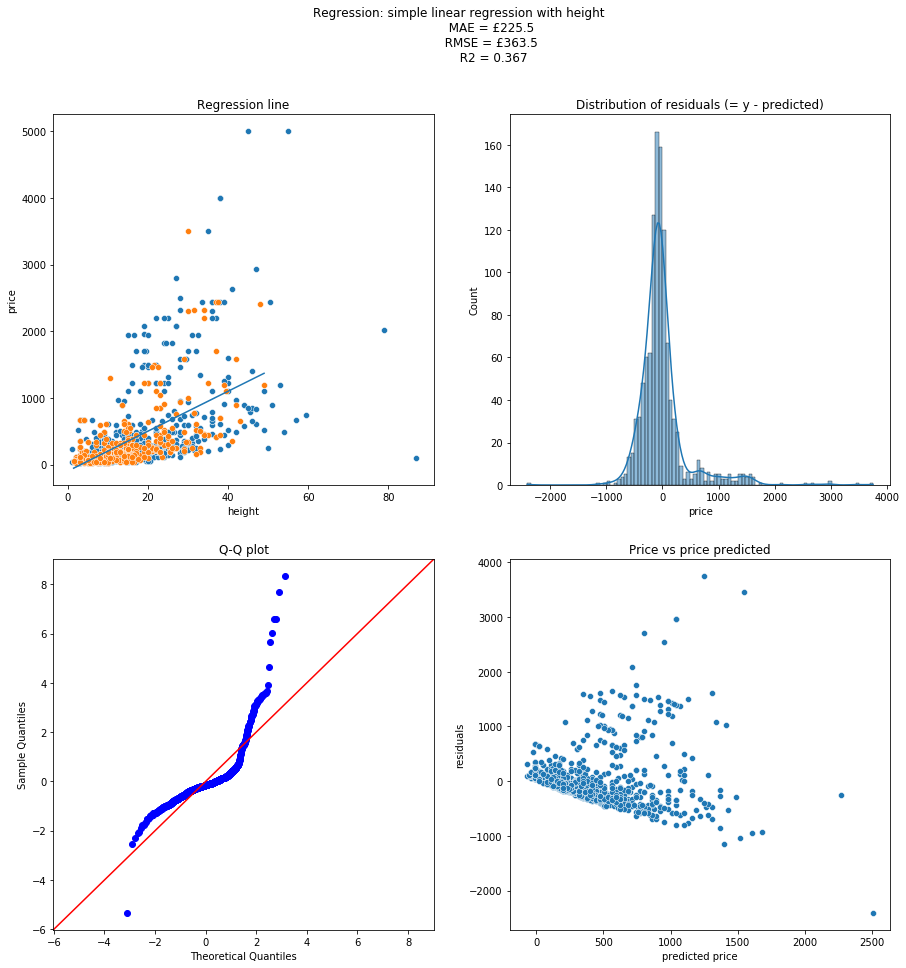

In [9]:
X = pots_reg[['height']]
y = pots_reg['price']

reg_plots(regressor, 'simple linear regression with height', LinearRegression())

Initial results with what is clearly the most important variable is already indicating that something will have to be done with the data in order to make it more appropriate for a regression analysis. 

To consider, and looking at the distribution of the residuals, is to apply some log-normal transformation. 

Additionally, I will consider stripping out the higher value pots, as it may well be that they are from a small and select number of makers only.

Firstly, let's try a multiple linear regression.

## Multiple linear regressions

intercept: -541.6
coefficients: {'height': 24.351624392125043, 'materials_Earthenware': -107.08983939188668, 'materials_Porcelain': 66.77552089464493, 'materials_Stoneware': 234.54177341015028, 'technique_Thrown': -94.78451066694205, 'firing_Gas': -59.877079908001285, 'firing_Raku': -94.86693099725647, 'firing_Wood': -94.01262399493245, 'decoration_Lustre': -34.60639881470376, 'decoration_Sgraffito': 194.3299288984274, 'decoration_Slip decoration': -18.798219424699607, 'decoration_Terra Sigillata': 556.9575507114114, 'length': 36.26693293062197}
MAE: 224.2
RMSE: 325.1
R^2: 0.494


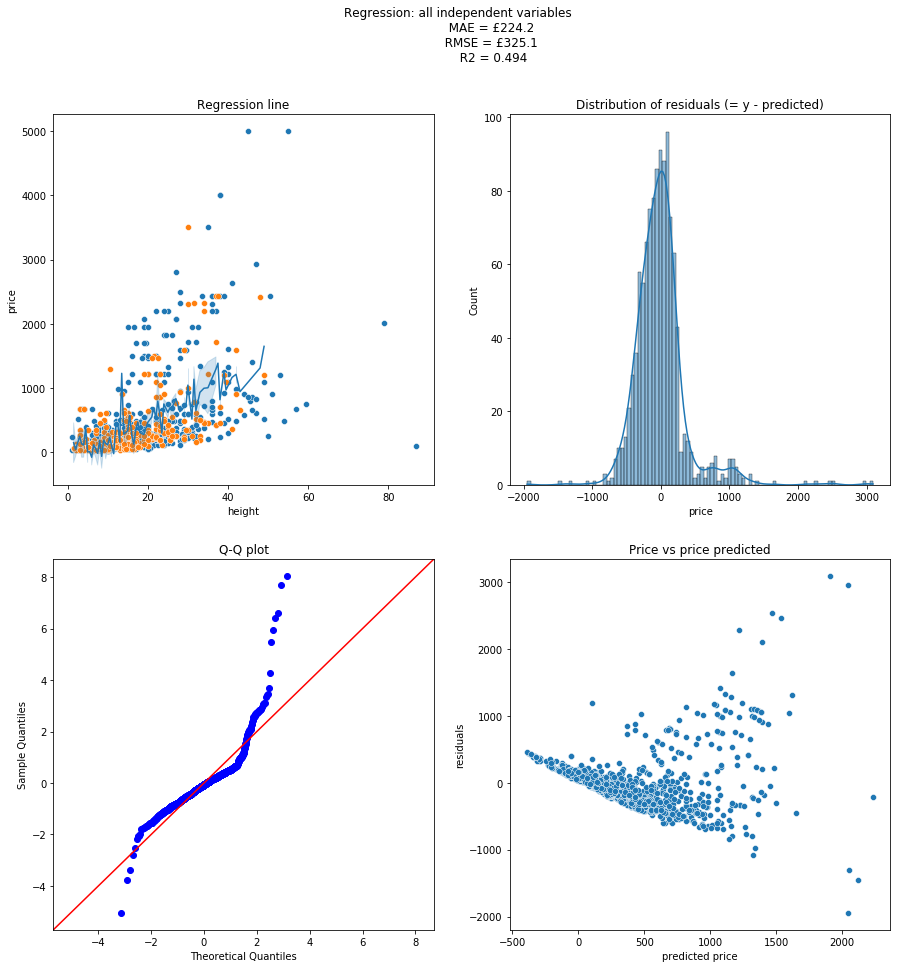

In [10]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

reg_plots(regressor, 'all independent variables', LinearRegression())

## High variance regressor

In [11]:
pots_reg.var().sort_values()

decoration_Terra Sigillata         0.003543
firing_Raku                        0.007061
decoration_Lustre                  0.014883
decoration_Sgraffito               0.021729
firing_Gas                         0.040034
firing_Wood                        0.131991
materials_Earthenware              0.188773
decoration_Slip decoration         0.202450
materials_Porcelain                0.212706
materials_Stoneware                0.243247
technique_Thrown                   0.246015
length                            38.556489
height                           113.121919
price                         302225.375575
dtype: float64

intercept: -494.4
coefficients: {'height': 24.45578031996363, 'materials_Earthenware': -123.42561213616614, 'materials_Porcelain': 14.826320574623185, 'materials_Stoneware': 176.74984474974227, 'technique_Thrown': -93.03935251700099, 'firing_Wood': -70.6873175869402, 'decoration_Slip decoration': -45.041003600455646, 'length': 36.34402120346894}
MAE: 225.5
RMSE: 327.6
R^2: 0.486


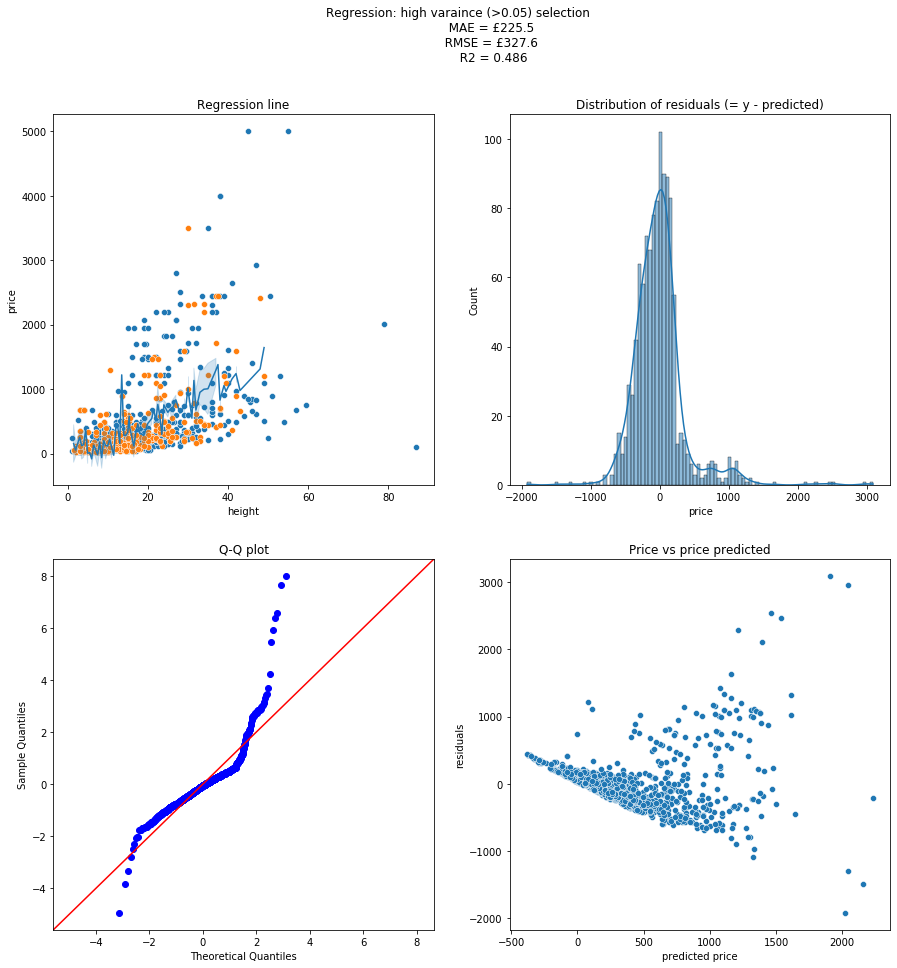

In [12]:
threshold = 0.05
X = pots_reg.drop(pots_reg.var()[pots_reg.var() < threshold].index.values, axis = 1)
X = X.drop('price', axis = 1)
y = pots_reg['price']

reg_plots(regressor, 'high varaince (>0.05) selection', LinearRegression())

## Log transformation regression (Simple)

In [17]:
def log_regressor(X, y, regression_class):
    
    y=np.log(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

    lin_reg = regression_class
    lin_reg.fit(X_train, y_train)

    print('intercept:', round(lin_reg.intercept_, 1))
    print('coefficients:', dict(zip(X.columns, lin_reg.coef_)))

    preds_train = lin_reg.predict(X_train)
    preds_test = lin_reg.predict(X_test)
    preds_all = lin_reg.predict(X)
    residuals = y - preds_all
    
    return X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals

intercept: 4.2
coefficients: {'height': 0.06581820781049626}
MAE: 0.6
RMSE: 0.8
R^2: 0.454


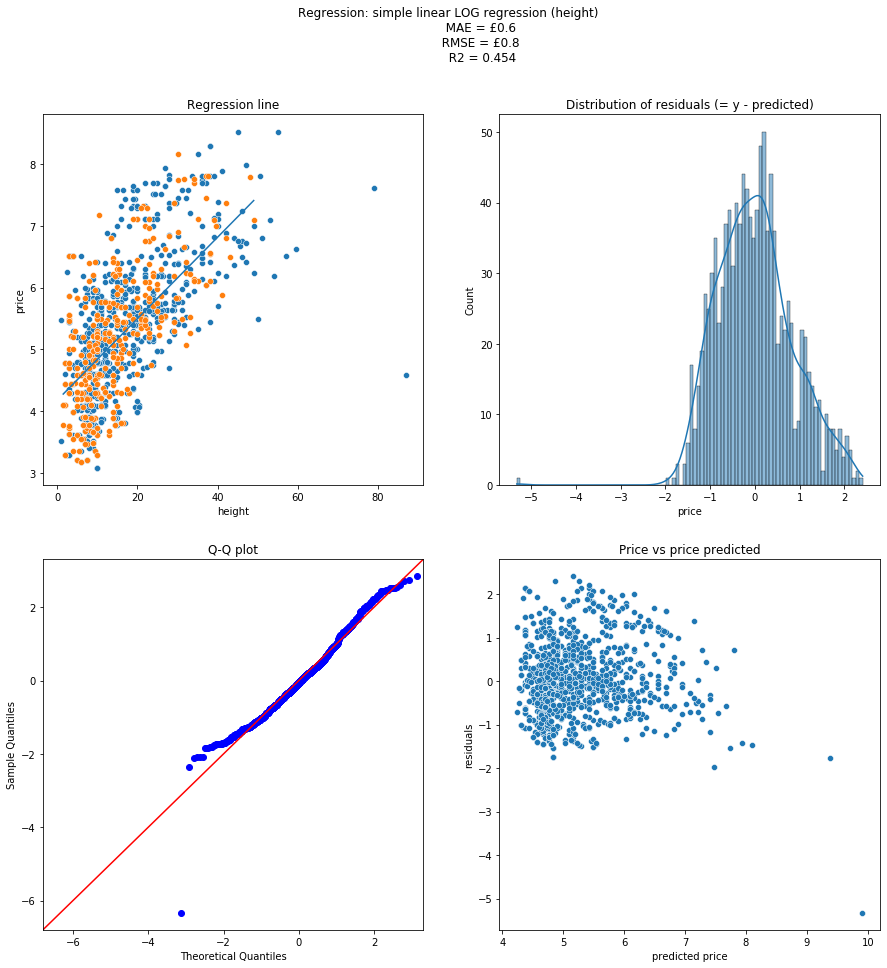

In [18]:
X = pots_reg[['height']]
y = pots_reg['price']

reg_plots(log_regressor, 'simple linear LOG regression (height)', LinearRegression())

## Log transformation (multiple)

intercept: 2.9
coefficients: {'height': 0.05482131416225334, 'materials_Earthenware': 0.06514797516004492, 'materials_Porcelain': 0.5649716705378816, 'materials_Stoneware': 0.6152286053554767, 'technique_Thrown': -0.33634700775282245, 'firing_Gas': -0.010623198752577709, 'firing_Raku': 0.41611179849485513, 'firing_Wood': 0.06979193969913855, 'decoration_Lustre': 0.3529139116131468, 'decoration_Sgraffito': 0.8324865074416441, 'decoration_Slip decoration': 0.08368328576681115, 'decoration_Terra Sigillata': 1.553920094735185, 'length': 0.0808282651058739}
MAE: 0.5
RMSE: 0.6
R^2: 0.647


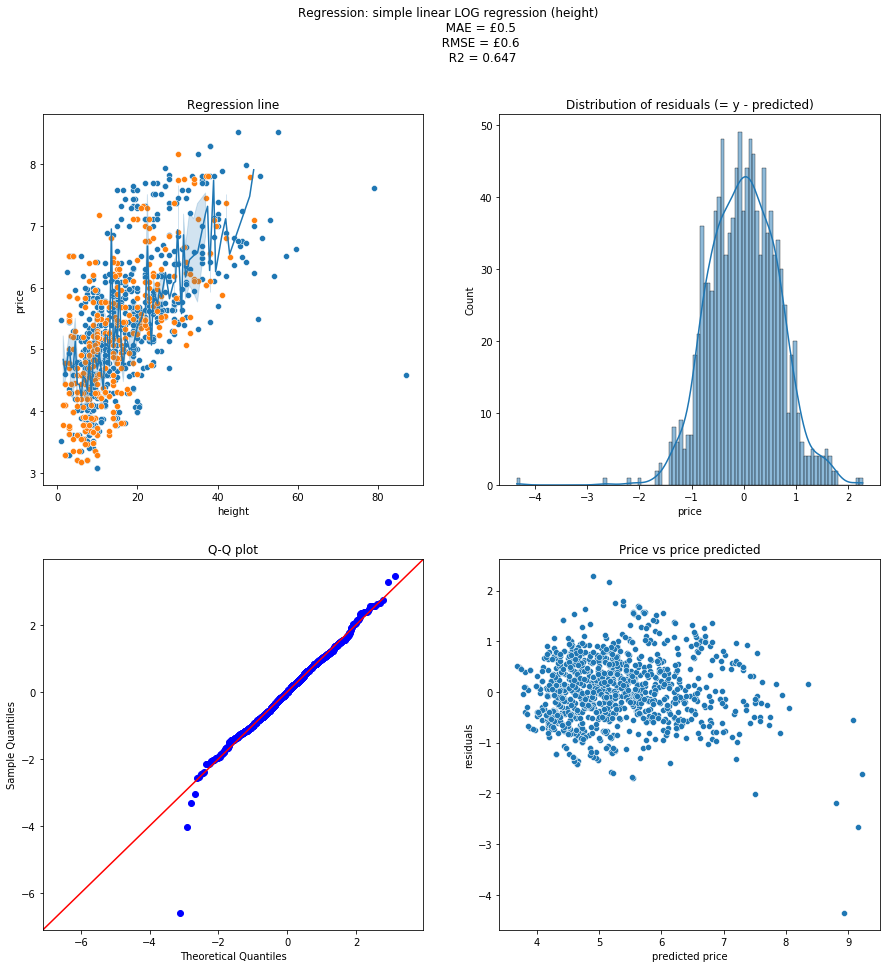

In [19]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

reg_plots(log_regressor, 'simple linear LOG regression (height)', LinearRegression())

## Log transformation (high variance only)

intercept: 3.1
coefficients: {'height': 0.05449891022045251, 'materials_Earthenware': -0.012806364439442441, 'materials_Porcelain': 0.3835512965343871, 'materials_Stoneware': 0.430690785732536, 'technique_Thrown': -0.3199585090411816, 'firing_Wood': 0.10250526422327236, 'decoration_Slip decoration': -0.012891400057547306, 'length': 0.08085242669863817}
MAE: 0.5
RMSE: 0.6
R^2: 0.643


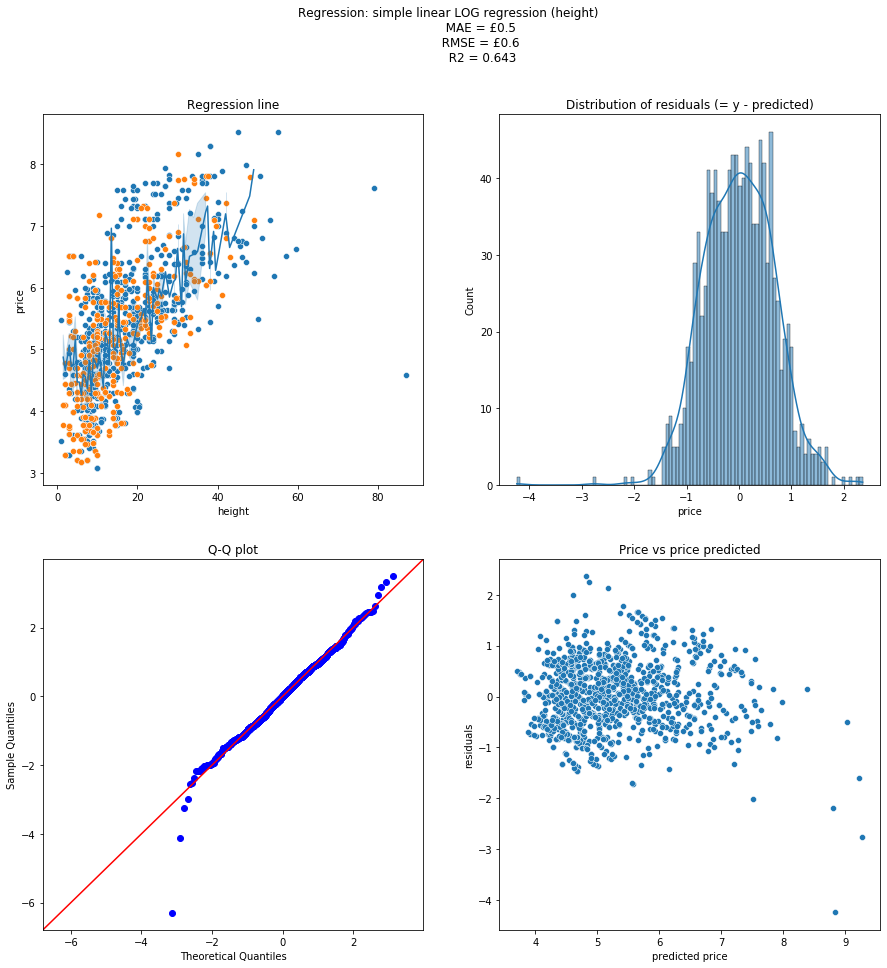

In [20]:
threshold = 0.05
X = pots_reg.drop(pots_reg.var()[pots_reg.var() < threshold].index.values, axis = 1)
X = X.drop('price', axis = 1)
y = pots_reg['price']

reg_plots(log_regressor, 'simple linear LOG regression (height)', LinearRegression())